In [1]:
from fastai.vision.all import *


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Fast_AI Street Modell

In [33]:
path = Path("/kaggle/input/car-street-data/train_test_split_car")
train_path = path/"train"
test_path = path/"test"

In [2]:
# define a function to get the images
def get_images(name):
    files = get_image_files("/kaggle/input/car-street-data/train_test_split_car")
    jpg_files = [f for f in files if f.suffix == '.jpg']
    return jpg_files

In [3]:
# define a function to get the numpy mask for the given path
def get_mask(path):
    #remove the file name and extension from the path
    path = path.parent 
    # add the name mask.npy to the path
    path = path.joinpath("label_street_mask.npy")
    return np.load(path)

In [4]:
#create a Datablock with the masks and images
satellite_block = DataBlock(blocks = (ImageBlock, MaskBlock(codes = ["background","street"])),
                            splitter=GrandparentSplitter(train_name='train', valid_name='test'),
                            get_items=get_images,
                            get_y=get_mask,
                            batch_tfms=aug_transforms(size=500, max_lighting=0.3)
)

In [5]:
#optimizer for better performance
opt_func = Adam

In [6]:
#create the dataloader based on the Datablock
dataloader = satellite_block.dataloaders("./", bs=10)

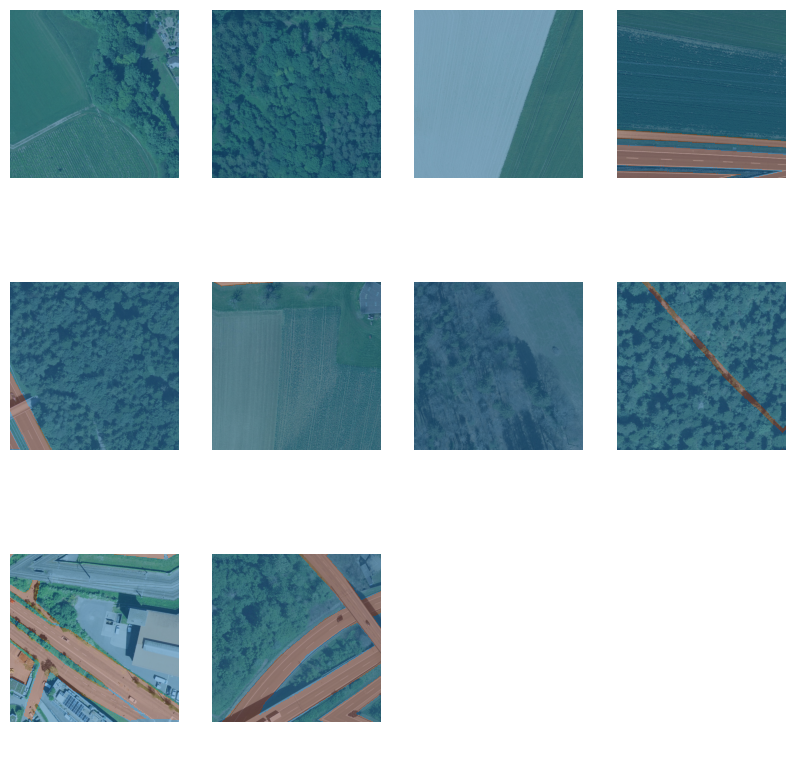

In [7]:
dataloader.show_batch(max_n=10, figsize=(10,10))

### create a learner and train it in a frozen state


In [8]:

learner = unet_learner(dataloader,resnet34,metrics=Dice,opt_func=opt_func)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 88.8MB/s]


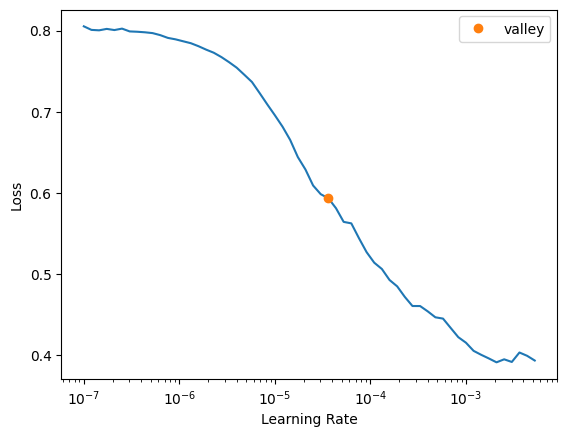

In [9]:
lr = learner.lr_find()

In [ ]:
learner.fit_one_cycle(20, lr_max=lr.valley, cbs=[EarlyStoppingCallback(monitor='dice', min_delta=0.01, patience=10, comp=np.greater),
                                           SaveModelCallback(monitor='dice', min_delta=0.01, comp=np.greater, fname='best_frozen_model')])

epoch,train_loss,valid_loss,dice,time
0,0.283836,0.213696,0.017637,02:32
1,0.153264,0.105645,0.679689,02:32
2,0.108646,0.085409,0.744748,02:32
3,0.101317,0.102302,0.740404,02:32
4,0.086451,0.076013,0.763314,02:32
5,0.082715,0.074263,0.768498,02:32
6,0.081431,0.073125,0.765552,02:32
7,0.079066,0.069115,0.790310,02:32
8,0.076969,0.066147,0.791944,02:32
9,0.073050,0.066546,0.806681,02:32


Better model found at epoch 0 with dice value: 0.017637274965819752.
Better model found at epoch 1 with dice value: 0.6796892233294998.
Better model found at epoch 2 with dice value: 0.7447481416730624.
Better model found at epoch 4 with dice value: 0.7633144701835659.
Better model found at epoch 7 with dice value: 0.7903096016413065.
Better model found at epoch 9 with dice value: 0.8066809428727001.


### create an unfrozen learner and train it

In [11]:
learner = learner.load('best_frozen_model')
learner.unfreeze()

/opt/conda/lib/python3.10/site-packages/fastai/learner.py:59: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


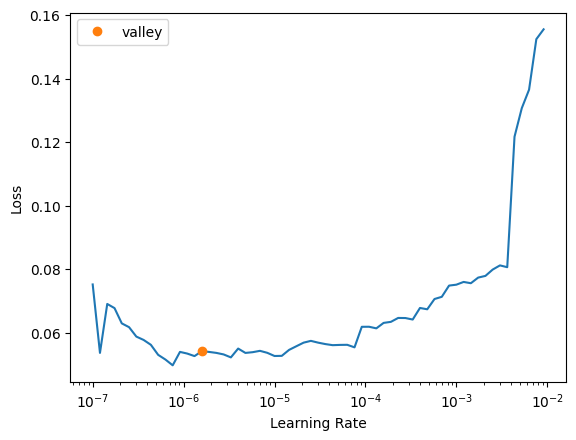

In [12]:
lr = learner.lr_find()

In [ ]:
learner.fit_one_cycle(
    20, lr_max=slice(lr.valley/10,lr.valley*10),
    cbs=[EarlyStoppingCallback(monitor='dice', min_delta=0.01, patience=10, comp=np.greater),
         SaveModelCallback(monitor='dice', comp=np.greater, fname='best_model')]
         )

epoch,train_loss,valid_loss,dice,time
0,0.058509,0.063217,0.815178,02:38
1,0.054948,0.063977,0.819283,02:38
2,0.053118,0.063029,0.818186,02:38
3,0.058723,0.065559,0.817645,02:38
4,0.058040,0.062121,0.819457,02:38
5,0.060494,0.068706,0.793663,02:38
6,0.057230,0.061763,0.819717,02:38
7,0.054013,0.066746,0.816252,02:38
8,0.055489,0.063539,0.826762,02:38
9,0.049766,0.062379,0.824074,02:38


Better model found at epoch 0 with dice value: 0.8151780195630206.
Better model found at epoch 1 with dice value: 0.8192833875397416.
Better model found at epoch 4 with dice value: 0.8194572023554003.
Better model found at epoch 6 with dice value: 0.8197172060855957.
Better model found at epoch 8 with dice value: 0.8267622222808084.


### check the performance with the dice score

In [14]:
learner = learner.load("best_model")

In [15]:
print("in-sample performance: {}".format(np.array(learner.validate(ds_idx=0)[1]))) # Dice Score

in-sample performance: 0.8688977901254235


In [16]:
print("out-of-sample performance: {}".format(np.array(learner.validate(ds_idx=1)[1]))) # Dice Score

out-of-sample performance: 0.8278523147218815


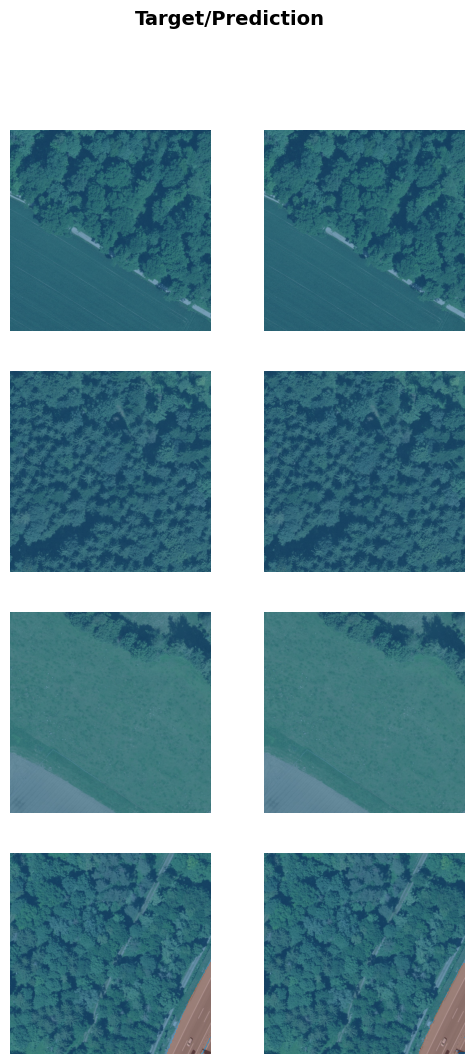

In [18]:
learner.show_results(max_n=4)

## Trying different Hyperparameters to see if the performance gets better

In [10]:
# creating the datablock with different hyperparameters
satellite_block_tuned = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=["background", "street"])),
    get_items=get_images,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),  # Änderung des Splitters zu RandomSplitter
    get_y=mask_function,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=256, max_lighting=0.3)
)

In [11]:
dataloader_tuned = satellite_block_tuned.dataloaders(path, bs=10)

In [14]:
learner_tuned = unet_learner(dataloader_tuned,resnet34,metrics=Dice,opt_func=opt_func)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 76.1MB/s]


### create a learner in a frozen state and learn it


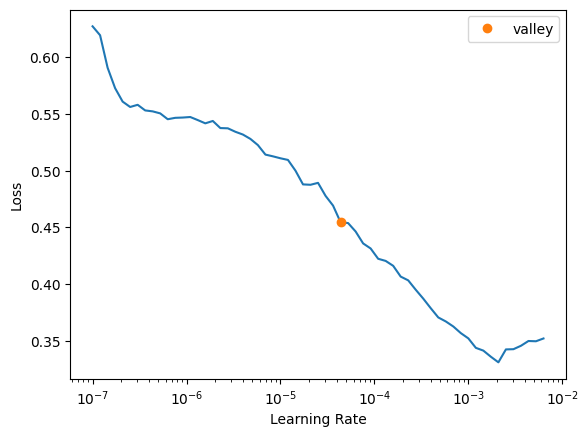

In [15]:
lr_tuned = learner_tuned.lr_find() 

In [16]:
learner_tuned.fit_one_cycle(20, lr_max=lr_tuned.valley,
                      cbs=[EarlyStoppingCallback(monitor='dice', min_delta=0.01, patience=10, comp=np.greater),
                           SaveModelCallback(monitor='dice', min_delta=0.01, comp=np.greater, fname='best_frozen_tuned_model')])

epoch,train_loss,valid_loss,dice,time
0,0.252276,0.175167,0.025080,00:59
1,0.148751,0.105229,0.625182,00:55
2,0.126750,0.086794,0.699111,00:55
3,0.102586,0.153693,0.618337,00:56
4,0.093331,0.071688,0.750128,00:55
5,0.106954,0.093308,0.757717,00:56
6,0.084075,0.064790,0.756661,00:55
7,0.083508,0.077177,0.766438,00:56
8,0.074868,0.062817,0.800135,00:55
9,0.071975,0.060128,0.798738,00:55


Better model found at epoch 0 with dice value: 0.0250803616138012.
Better model found at epoch 1 with dice value: 0.6251819324963573.
Better model found at epoch 2 with dice value: 0.6991109715919308.
Better model found at epoch 4 with dice value: 0.7501279220443448.
Better model found at epoch 7 with dice value: 0.7664377068724291.
Better model found at epoch 8 with dice value: 0.800135374330172.
Better model found at epoch 15 with dice value: 0.8111604467761824.


In [20]:
# Modell laden und unfreezen
learner_tuned = learner_tuned.load('best_frozen_tuned_model')
learner_tuned.unfreeze()

### unfreeze the learner and train it again

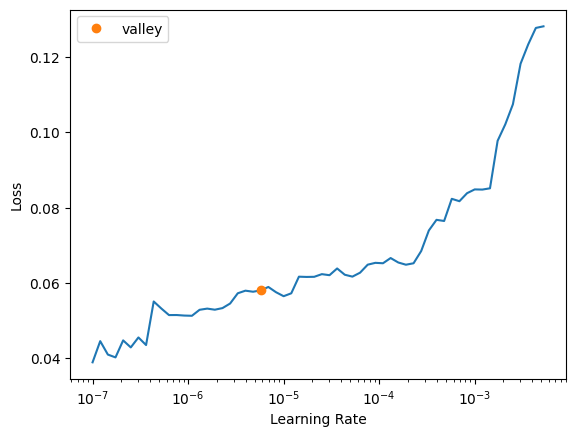

In [21]:
lr_tuned = learner_tuned.lr_find() 

In [26]:
learner_tuned.fit_one_cycle(
    20, lr_max=slice(lr_tuned.valley / 10, lr_tuned.valley * 10),
    cbs=[
        EarlyStoppingCallback(monitor='dice', min_delta=0.01, patience=10, comp=np.greater),
        SaveModelCallback(monitor='dice', comp=np.greater, fname='best_tuned_model')
    ]
)

epoch,train_loss,valid_loss,dice,time
0,0.043074,0.055101,0.828432,01:00
1,0.040591,0.057061,0.827925,01:00
2,0.042758,0.054123,0.828358,01:01
3,0.049436,0.052396,0.819780,01:02
4,0.046120,0.057546,0.819710,01:02
5,0.045777,0.058253,0.820013,01:01
6,0.044142,0.051218,0.831720,01:00
7,0.045576,0.061191,0.810233,01:00
8,0.040503,0.059024,0.824446,01:00
9,0.041960,0.051566,0.829179,01:01


Better model found at epoch 0 with dice value: 0.828431570119157.
Better model found at epoch 6 with dice value: 0.8317195012808445.
No improvement since epoch 0: early stopping


### check the performance

In [27]:
learner_tuned = learner_tuned.load('best_tuned_model')

In [28]:
print("out-of-sample performance: {}".format(np.array(learner_tuned.validate(ds_idx=1)[1]))) # Dice Score

out-of-sample performance: 0.8317195012808445


In [29]:
print("In-Sample Performance: {}".format(np.array(learner_tuned.validate(ds_idx=0)[1])))  # Dice Score

In-Sample Performance: 0.884161366593624
